### This Notebook takes the previously created BC ignoring the NEMO Levels and JP practical salinity and does the vertical interpolation and gsw calls to generate proper salinity to write them into final input BC file one for each boundary

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from salishsea_tools import (nc_tools, gsw_calls,viz_tools)
from fancyimpute import KNN

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


##### Import the mesh_mask.nc for the depth levels on which to interpolate our values (We will use the mask recently created with 27 depth levels after playing with the NEMO parameters)

In [2]:
mask = nc.Dataset('/ocean/ssahu/CANYONS/Runs/trial_run_mesh_mask_gen/mesh_mask.nc')

#mask = nc.Dataset('/ocean/ssahu/CANYONS/Results/Westcoast_attempt17_generate_mask_80_levels/mesh_mask.nc')

NEMO_depth_T = mask.variables['nav_lev'][:];

print(NEMO_depth_T.shape)

(27,)


In [3]:
NEMO_depth_T

array([   14.75075722,    24.42877769,    34.46412659,    45.19285583,
          57.26233673,    71.90678406,    91.43279266,   119.99002075,
         164.52903748,   235.26014709,   344.00537109,   499.3053894 ,
         701.16015625,   941.02905273,  1207.08996582,  1489.1328125 ,
        1780.20678711,  2076.16235352,  2374.69287109,  2674.56420898,
        2975.12866211,  3276.05078125,  3577.15649414,  3878.35668945,
        4179.60546875,  4480.87939453,  4782.16601562], dtype=float32)

#### Let us start with the left boundary (West)

##### The 2D output BC fields are fine so we donot need to worry about them and they have been properly created by the previous notebook (Writing_bdy_files) but the fields inside the 3d boundary files have not been interpolated and the salinity values need to be converted to absolute salinity from PSU

In [4]:
left_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_west_m04.nc');

vosaline_JP_level_PSU_left = left_file.variables['vosaline'][:];
votemper_JP_level_PT_left = left_file.variables['votemper'][:];
U_vel_JP_level_left = left_file.variables['vozocrtx'][:];
V_vel_JP_level_left = left_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_left.shape, votemper_JP_level_PT_left.shape, U_vel_JP_level_left.shape, V_vel_JP_level_left.shape)

(43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100)


#### Our boundary files donot have a depth variable from which we can import the depths but the files created before the vertical interpolation of the IC values have the depth variable (the file is called West_coast_temperature_salinity_nomask_JP.nc)

In [5]:
depth_JP_T = nc.Dataset('/home/ssahu/saurav/JP_BC/cat_42_days_T.nc').variables['deptht'][:];
lat = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc')\
            .variables['nav_lat'][:];
lon = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc')\
            .variables['nav_lon'][:]
print(depth_JP_T.shape, lat.shape)

(50,) (100, 70)


In [6]:
# Conversion of vosaline_PSU to vosaline_RS and votemper_PT to votemper_CT

z = np.dot(-1,depth_JP_T);

pressure = np.zeros(z.shape);
lats = np.zeros(pressure.shape);
lons = np.zeros(pressure.shape);
lats[:] = np.mean(lat);
lons[:] = np.mean(lon);

vosaline_JP_level_SA_left = np.zeros(vosaline_JP_level_PSU_left.shape);
vosaline_JP_level_RS_left = np.zeros(vosaline_JP_level_PSU_left.shape);
votemper_JP_level_CT_left = np.zeros(vosaline_JP_level_PSU_left.shape);

pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);
for i,j in enumerate(vosaline_JP_level_SA_left[0,:,...]):
    vosaline_JP_level_SA_left[:,i,...] = gsw_calls.generic_gsw_caller('gsw_SA_from_SP', [vosaline_JP_level_PSU_left[:,i,...],pressure[i],lons[i],lats[i]]);

vosaline_JP_level_RS_left[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_left[:]]);
votemper_JP_level_CT_left[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_left[:], votemper_JP_level_PT_left[:]]);

In [7]:
vosaline_JP_level_RS_left.shape, U_vel_JP_level_left.shape

((43, 50, 4, 100), (43, 50, 4, 100))

#### Now let us fill up the holes before going doing the vertical interpolation

In [8]:
try:
    for p,q in enumerate(vosaline_JP_level_RS_left[:,...]):
        for i,j in enumerate(vosaline_JP_level_RS_left[p,:,...]):
            votemper_JP_level_CT_left[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_left[p,i,...]);
            vosaline_JP_level_RS_left[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_left[p,i,...]);
            U_vel_JP_level_left[p,i,...] = KNN(k=3).complete(U_vel_JP_level_left[p,i,...]);
            V_vel_JP_level_left[p,i,...] = KNN(k=3).complete(V_vel_JP_level_left[p,i,...]);
except:
    pass

votemper_JP_level_CT_left[np.where(np.isnan(votemper_JP_level_CT_left))]=0;
vosaline_JP_level_RS_left[np.where(np.isnan(vosaline_JP_level_RS_left))]=0;
U_vel_JP_level_left[np.where(np.isnan(U_vel_JP_level_left))]=0;
V_vel_JP_level_left[np.where(np.isnan(V_vel_JP_level_left))]=0;

for a,b in enumerate(vosaline_JP_level_RS_left[:,...]):
    for i,j in enumerate(vosaline_JP_level_RS_left[a,:,...]):
        for p,q in enumerate(vosaline_JP_level_RS_left[a,i,:,...]):
            for l,m in enumerate(vosaline_JP_level_RS_left[a,i,p,:]):
                if vosaline_JP_level_RS_left[a,i,p,l] == 0:
                    vosaline_JP_level_RS_left[a,i,p,l] = vosaline_JP_level_RS_left[a,i,p-1,l]
                else:
                    continue
                if votemper_JP_level_CT_left[a,i,p,l] == 0:
                    votemper_JP_level_CT_left[a,i,p,l] = votemper_JP_level_CT_left[a,i,p-1,l]
                else:
                    continue
                if U_vel_JP_level_left[a,i,p,l] == 0:
                    U_vel_JP_level_left[a,i,p,l] = U_vel_JP_level_left[a,i,p-1,l]
                else:
                    continue
                if V_vel_JP_level_left[a,i,p,l] == 0:
                    V_vel_JP_level_left[a,i,p,l] = V_vel_JP_level_left[a,i,p-1,l]
                else:
                    continue



In [9]:
#### let us interp1d to make a vertical function for each of these variables and then interpolate them to the values vertically

left_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
left_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
left_U_function = interp1d(depth_JP_T, U_vel_JP_level_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
left_V_function = interp1d(depth_JP_T, V_vel_JP_level_left, axis=1,\
                              bounds_error=False, fill_value='extrapolate');

In [10]:
votemper_NEMO_left = np.zeros((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));
vosaline_NEMO_left = np.zeros((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));
U_NEMO_left = np.zeros((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));
V_NEMO_left = np.zeros((vosaline_JP_level_SA_left.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_left.shape[2], vosaline_JP_level_SA_left.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_left[:,indx,...] = left_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_left[:,indx,...] = left_sal_function(NEMO_depth_T[indx]);
    U_NEMO_left[:,indx,...]        = left_U_function(NEMO_depth_T[indx]);
    V_NEMO_left[:,indx,...]        = left_V_function(NEMO_depth_T[indx]);

In [11]:
print(votemper_NEMO_left.shape, vosaline_NEMO_left.shape, U_NEMO_left.shape, V_NEMO_left.shape)

(43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100)


#### Now we will take the values from the created nc file of initial conditions to make the BC same as the ic file for the first time step

ic_file = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_NEMO_IC_temperature_salinity_nomask_JP.nc');

ic_temp = ic_file.variables['votemper'][:]; ic_sal = ic_file.variables['vosaline'][:];
ic_temp = np.transpose(ic_temp,(0,1,3,2)); ic_sal = np.transpose(ic_sal,(0,1,3,2)); 

bc_temp_left = ic_temp[0,:,:4,:];
bc_sal_left = ic_sal[0,:,:4,:];

bc_temp_right = ic_temp[0,:,-4:,:];
bc_sal_right = ic_sal[0,:,:4,:];

ic_temp = np.transpose(ic_temp, (0,1,3,2));
ic_sal = np.transpose(ic_sal, (0,1,3,2));

bc_temp_north = ic_temp[0,:,-4:,:];
bc_sal_north = ic_sal[0,:,-4:,:];

bc_temp_south = ic_temp[0,:,:4,:];
bc_sal_south = ic_sal[0,:,:4,:];




print(ic_temp.shape, bc_temp_left.shape, bc_temp_right.shape, bc_temp_north.shape, bc_temp_south.shape)

### Saving it as the first time step BC

for i in [0,1,2,3,4]:
    votemper_NEMO_left[i,...] = bc_temp_left[...];
    vosaline_NEMO_left[i,...] = bc_sal_left[...];


In [12]:
#Now let us write the 3d boundary condition for the left boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_west_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_left.shape[3]);
bdy_file.createDimension('yb', U_NEMO_left.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_left.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along left boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of left boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_left[:];
vomecrty[:] = V_NEMO_left[:];
votemper[:] = votemper_NEMO_left[:];
vosaline[:] = vosaline_NEMO_left[:];
deptht[:] = NEMO_depth_T[:];

#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];


bdy_file.close()

### Now for the right boundary

In [13]:
# for the right boundary I will make everything occur within one cell so that eventually it will be easier to automate it

right_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_right_m04.nc');

vosaline_JP_level_PSU_right = right_file.variables['vosaline'][:];
votemper_JP_level_PT_right = right_file.variables['votemper'][:];
U_vel_JP_level_right = right_file.variables['vozocrtx'][:];
V_vel_JP_level_right = right_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_right.shape, votemper_JP_level_PT_right.shape, U_vel_JP_level_right.shape, V_vel_JP_level_right.shape)

vosaline_JP_level_SA_right = np.zeros(vosaline_JP_level_PSU_right.shape);
vosaline_JP_level_RS_right = np.zeros(vosaline_JP_level_PSU_right.shape);
votemper_JP_level_CT_right = np.zeros(vosaline_JP_level_PSU_right.shape);


pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);

for i,j in enumerate(vosaline_JP_level_SA_right[0,:,...]):
    vosaline_JP_level_SA_right[:,i,...] = gsw_calls.generic_gsw_caller(\
                                    'gsw_SA_from_SP', [vosaline_JP_level_PSU_right[:,i,...],pressure[i],lons[i],lats[i]]);

vosaline_JP_level_RS_right[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_right[:]]);
votemper_JP_level_CT_right[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_right[:], votemper_JP_level_PT_right[:]]);    
    
print(vosaline_JP_level_SA_right.shape)

try:
    for p,q in enumerate(vosaline_JP_level_RS_right[:,...]):
        for i,j in enumerate(vosaline_JP_level_RS_right[p,:,...]):
            votemper_JP_level_CT_right[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_right[p,i,...]);
            vosaline_JP_level_RS_right[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_right[p,i,...]);
            U_vel_JP_level_right[p,i,...] = KNN(k=3).complete(U_vel_JP_level_right[p,i,...]);
            V_vel_JP_level_right[p,i,...] = KNN(k=3).complete(V_vel_JP_level_right[p,i,...]);
except:
    pass

votemper_JP_level_CT_right[np.where(np.isnan(votemper_JP_level_CT_right))]=0;
vosaline_JP_level_RS_right[np.where(np.isnan(vosaline_JP_level_RS_right))]=0;
U_vel_JP_level_right[np.where(np.isnan(U_vel_JP_level_right))]=0;
V_vel_JP_level_right[np.where(np.isnan(V_vel_JP_level_right))]=0;

for a,b in enumerate(vosaline_JP_level_RS_right[:,...]):
    for i,j in enumerate(vosaline_JP_level_RS_right[a,:,...]):
        for p,q in enumerate(vosaline_JP_level_RS_right[a,i,:,...]):
            for l,m in enumerate(vosaline_JP_level_RS_right[a,i,p,:]):
                if vosaline_JP_level_RS_right[a,i,p,l] == 0:
                    vosaline_JP_level_RS_right[a,i,p,l] = vosaline_JP_level_RS_right[a,i,p-1,l]
                else:
                    continue
                if votemper_JP_level_CT_right[a,i,p,l] == 0:
                    votemper_JP_level_CT_right[a,i,p,l] = votemper_JP_level_CT_right[a,i,p-1,l]
                else:
                    continue
                if U_vel_JP_level_right[a,i,p,l] == 0:
                    U_vel_JP_level_right[a,i,p,l] = U_vel_JP_level_right[a,i,p-1,l]
                else:
                    continue
                if V_vel_JP_level_right[a,i,p,l] == 0:
                    V_vel_JP_level_right[a,i,p,l] = V_vel_JP_level_right[a,i,p-1,l]
                else:
                    continue


right_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_right, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
right_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_right, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
right_U_function = interp1d(depth_JP_T, U_vel_JP_level_right,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
right_V_function = interp1d(depth_JP_T, V_vel_JP_level_right, axis=1,\
                              bounds_error=False, fill_value='extrapolate');


votemper_NEMO_right = np.zeros((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));
vosaline_NEMO_right = np.zeros((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));
U_NEMO_right = np.zeros((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));
V_NEMO_right = np.zeros((vosaline_JP_level_SA_right.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_right.shape[2], vosaline_JP_level_SA_right.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_right[:,indx,...] = right_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_right[:,indx,...] = right_sal_function(NEMO_depth_T[indx]);
    U_NEMO_right[:,indx,...]        = right_U_function(NEMO_depth_T[indx]);
    V_NEMO_right[:,indx,...]        = right_V_function(NEMO_depth_T[indx]);

    
print(votemper_NEMO_right.shape, vosaline_NEMO_right.shape, U_NEMO_right.shape, V_NEMO_right.shape)

(43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100) (43, 50, 4, 100)
(43, 50, 4, 100)
(43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100) (43, 27, 4, 100)


for i in [0,1,2,3,4]:
    votemper_NEMO_right[i,...] = bc_temp_right[...];
    vosaline_NEMO_right[i,...] = bc_sal_right[...];

In [14]:
#Now let us write the 3d boundary condition for the right boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_right_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_right.shape[3]);
bdy_file.createDimension('yb', U_NEMO_right.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_right.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along right boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of right boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_right[:,:,:,:];
vomecrty[:] = V_NEMO_right[:,:,:,:];
votemper[:] = votemper_NEMO_right[:,:,:,:];
vosaline[:] = vosaline_NEMO_right[:,:,:,:];
deptht[:] = NEMO_depth_T[:];

#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];

bdy_file.close()

### Now for the north boundary

In [15]:
north_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_north_m04.nc');

vosaline_JP_level_PSU_north = north_file.variables['vosaline'][:];
votemper_JP_level_PT_north = north_file.variables['votemper'][:];
U_vel_JP_level_north = north_file.variables['vozocrtx'][:];
V_vel_JP_level_north = north_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_north.shape, votemper_JP_level_PT_north.shape, U_vel_JP_level_north.shape, V_vel_JP_level_north.shape)

vosaline_JP_level_SA_north = np.zeros(vosaline_JP_level_PSU_north.shape);
vosaline_JP_level_RS_north = np.zeros(vosaline_JP_level_PSU_north.shape);
votemper_JP_level_CT_north = np.zeros(vosaline_JP_level_PSU_north.shape);

pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);

for i,j in enumerate(vosaline_JP_level_SA_north[0,:,...]):
    vosaline_JP_level_SA_north[:,i,...] = gsw_calls.generic_gsw_caller(\
                                    'gsw_SA_from_SP', [vosaline_JP_level_PSU_north[:,i,...],pressure[i],lons[i],lats[i]]);

vosaline_JP_level_RS_north[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_north[:]]);
votemper_JP_level_CT_north[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_north[:], votemper_JP_level_PT_north[:]]);        
    
print(vosaline_JP_level_RS_north.shape)


try:
    for p,q in enumerate(vosaline_JP_level_RS_north[:,...]):
        for i,j in enumerate(vosaline_JP_level_RS_north[p,:,...]):
            votemper_JP_level_CT_north[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_north[p,i,...]);
            vosaline_JP_level_RS_north[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_north[p,i,...]);
            U_vel_JP_level_north[p,i,...] = KNN(k=3).complete(U_vel_JP_level_north[p,i,...]);
            V_vel_JP_level_north[p,i,...] = KNN(k=3).complete(V_vel_JP_level_north[p,i,...]);
except:
    pass

votemper_JP_level_CT_north[np.where(np.isnan(votemper_JP_level_CT_north))]=0;
vosaline_JP_level_RS_north[np.where(np.isnan(vosaline_JP_level_RS_north))]=0;
U_vel_JP_level_north[np.where(np.isnan(U_vel_JP_level_north))]=0;
V_vel_JP_level_north[np.where(np.isnan(V_vel_JP_level_north))]=0;

for a,b in enumerate(vosaline_JP_level_RS_north[:,...]):
    for i,j in enumerate(vosaline_JP_level_RS_north[a,:,...]):
        for p,q in enumerate(vosaline_JP_level_RS_north[a,i,:,...]):
            for l,m in enumerate(vosaline_JP_level_RS_north[a,i,p,:]):
                if vosaline_JP_level_RS_north[a,i,p,l] == 0:
                    vosaline_JP_level_RS_north[a,i,p,l] = vosaline_JP_level_RS_north[a,i,p-1,l]
                else:
                    continue
                if votemper_JP_level_CT_north[a,i,p,l] == 0:
                    votemper_JP_level_CT_north[a,i,p,l] = votemper_JP_level_CT_north[a,i,p-1,l]
                else:
                    continue
                if U_vel_JP_level_north[a,i,p,l] == 0:
                    U_vel_JP_level_north[a,i,p,l] = U_vel_JP_level_north[a,i,p-1,l]
                else:
                    continue
                if V_vel_JP_level_north[a,i,p,l] == 0:
                    V_vel_JP_level_north[a,i,p,l] = V_vel_JP_level_north[a,i,p-1,l]
                else:
                    continue


north_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_north, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
north_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_north, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
north_U_function = interp1d(depth_JP_T, U_vel_JP_level_north,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
north_V_function = interp1d(depth_JP_T, V_vel_JP_level_north, axis=1,\
                              bounds_error=False, fill_value='extrapolate');


votemper_NEMO_north = np.zeros((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));
vosaline_NEMO_north = np.zeros((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));
U_NEMO_north = np.zeros((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));
V_NEMO_north = np.zeros((vosaline_JP_level_SA_north.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_north.shape[2], vosaline_JP_level_SA_north.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_north[:,indx,...] = north_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_north[:,indx,...] = north_sal_function(NEMO_depth_T[indx]);
    U_NEMO_north[:,indx,...]        = north_U_function(NEMO_depth_T[indx]);
    V_NEMO_north[:,indx,...]        = north_V_function(NEMO_depth_T[indx]);

    
print(votemper_NEMO_north.shape, vosaline_NEMO_north.shape, U_NEMO_north.shape, V_NEMO_north.shape)

(43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70)
(43, 50, 4, 70)
(43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70)


for i in [0,1,2,3,4]:
    votemper_NEMO_north[i,...] = bc_temp_north[...];
    vosaline_NEMO_north[i,...] = bc_sal_north[...];

In [16]:
#Now let us write the 3d boundary condition for the north boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_north_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_north.shape[3]);
bdy_file.createDimension('yb', U_NEMO_north.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_north.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along north boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of north boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_north[:,:,:,:];
vomecrty[:] = V_NEMO_north[:,:,:,:];
votemper[:] = votemper_NEMO_north[:,:,:,:];
vosaline[:] = vosaline_NEMO_north[:,:,:,:];
deptht[:] = NEMO_depth_T[:];


#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];

bdy_file.close()

### Now for the south boundary

In [17]:
south_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_south_m04.nc');

vosaline_JP_level_PSU_south = south_file.variables['vosaline'][:];
votemper_JP_level_PT_south = south_file.variables['votemper'][:];
U_vel_JP_level_south = south_file.variables['vozocrtx'][:];
V_vel_JP_level_south = south_file.variables['vomecrty'][:];


print(vosaline_JP_level_PSU_south.shape, votemper_JP_level_PT_south.shape, U_vel_JP_level_south.shape, V_vel_JP_level_south.shape)

vosaline_JP_level_SA_south = np.zeros(vosaline_JP_level_PSU_south.shape);
vosaline_JP_level_RS_south = np.zeros(vosaline_JP_level_PSU_south.shape);
votemper_JP_level_CT_south = np.zeros(votemper_JP_level_PT_south.shape);



pressure = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z, np.mean(lat)]);

for i,j in enumerate(vosaline_JP_level_SA_south[0,:,...]):
    vosaline_JP_level_SA_south[:,i,...] = gsw_calls.generic_gsw_caller(\
                                    'gsw_SA_from_SP', [vosaline_JP_level_PSU_south[:,i,...],pressure[i],lons[i],lats[i]]);
vosaline_JP_level_RS_south[:] = gsw_calls.generic_gsw_caller('gsw_SR_from_SP', [vosaline_JP_level_PSU_south[:]]);
votemper_JP_level_CT_south[:] = gsw_calls.generic_gsw_caller('gsw_CT_from_pt', [vosaline_JP_level_SA_south[:], votemper_JP_level_PT_south[:]]);        
    
print(vosaline_JP_level_SA_south.shape)


try:
    for p,q in enumerate(vosaline_JP_level_RS_south[:,...]):
        for i,j in enumerate(vosaline_JP_level_RS_south[p,:,...]):
            votemper_JP_level_CT_south[p,i,...] = KNN(k=3).complete(votemper_JP_level_CT_south[p,i,...]);
            vosaline_JP_level_RS_south[p,i,...] = KNN(k=3).complete(vosaline_JP_level_RS_south[p,i,...]);
            U_vel_JP_level_south[p,i,...] = KNN(k=3).complete(U_vel_JP_level_south[p,i,...]);
            V_vel_JP_level_south[p,i,...] = KNN(k=3).complete(V_vel_JP_level_south[p,i,...]);
except:
    pass

votemper_JP_level_CT_south[np.where(np.isnan(votemper_JP_level_CT_south))]=0;
vosaline_JP_level_RS_south[np.where(np.isnan(vosaline_JP_level_RS_south))]=0;
U_vel_JP_level_south[np.where(np.isnan(U_vel_JP_level_south))]=0;
V_vel_JP_level_south[np.where(np.isnan(V_vel_JP_level_south))]=0;

for a,b in enumerate(vosaline_JP_level_RS_south[:,...]):
    for i,j in enumerate(vosaline_JP_level_RS_south[a,:,...]):
        for p,q in enumerate(vosaline_JP_level_RS_south[a,i,:,...]):
            for l,m in enumerate(vosaline_JP_level_RS_south[a,i,p,:]):
                if vosaline_JP_level_RS_south[a,i,p,l] == 0:
                    vosaline_JP_level_RS_south[a,i,p,l] = vosaline_JP_level_RS_south[a,i,p-1,l]
                else:
                    continue
                if votemper_JP_level_CT_south[a,i,p,l] == 0:
                    votemper_JP_level_CT_south[a,i,p,l] = votemper_JP_level_CT_south[a,i,p-1,l]
                else:
                    continue
                if U_vel_JP_level_south[a,i,p,l] == 0:
                    U_vel_JP_level_south[a,i,p,l] = U_vel_JP_level_south[a,i,p-1,l]
                else:
                    continue
                if V_vel_JP_level_south[a,i,p,l] == 0:
                    V_vel_JP_level_south[a,i,p,l] = V_vel_JP_level_south[a,i,p-1,l]
                else:
                    continue

south_temp_function = interp1d(depth_JP_T, votemper_JP_level_CT_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_sal_function = interp1d(depth_JP_T, vosaline_JP_level_RS_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_U_function = interp1d(depth_JP_T, U_vel_JP_level_south,axis=1,\
                              bounds_error=False, fill_value='extrapolate');
south_V_function = interp1d(depth_JP_T, V_vel_JP_level_south, axis=1,\
                              bounds_error=False, fill_value='extrapolate');


votemper_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
vosaline_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
U_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));
V_NEMO_south = np.zeros((vosaline_JP_level_SA_south.shape[0], NEMO_depth_T.shape[0], \
                               vosaline_JP_level_SA_south.shape[2], vosaline_JP_level_SA_south.shape[3]));


for indx in np.arange(NEMO_depth_T.shape[0]):
    votemper_NEMO_south[:,indx,...] = south_temp_function(NEMO_depth_T[indx]);
    vosaline_NEMO_south[:,indx,...] = south_sal_function(NEMO_depth_T[indx]);
    U_NEMO_south[:,indx,...]        = south_U_function(NEMO_depth_T[indx]);
    V_NEMO_south[:,indx,...]        = south_V_function(NEMO_depth_T[indx]);

    
print(votemper_NEMO_south.shape, vosaline_NEMO_south.shape, U_NEMO_south.shape, V_NEMO_south.shape)

(43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70) (43, 50, 4, 70)
(43, 50, 4, 70)
(43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70) (43, 27, 4, 70)


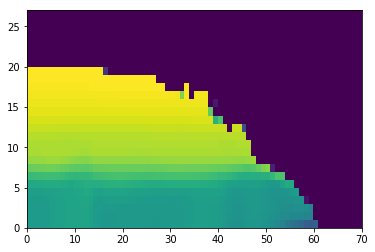

In [18]:
plt.pcolormesh(vosaline_NEMO_south[0,:,3,:], vmin =30)

In [19]:
np.min(vosaline_NEMO_south[0,:,3,:])

0.0

for i in [0,1,2,3,4]:
    votemper_NEMO_south[i,...] = bc_temp_south[...];
    vosaline_NEMO_south[i,...] = bc_sal_south[...];

In [20]:
#Now let us write the 3d boundary condition for the south boundary

bdy_file = nc.Dataset('/ocean/ssahu/CANYONS/bdy_files/3d_NEMO_south_m04.nc', 'w', zlib=True);


bdy_file.createDimension('xb', U_NEMO_south.shape[3]);
bdy_file.createDimension('yb', U_NEMO_south.shape[2]);
bdy_file.createDimension('deptht', U_NEMO_south.shape[1]);
bdy_file.createDimension('time_counter', None);


xb = bdy_file.createVariable('xb', 'int32', ('xb',), zlib=True);
xb.units = 'indices';
xb.longname = 'x indices along south boundary';

yb = bdy_file.createVariable('yb', 'int32', ('yb',), zlib=True);
yb.units = 'indices';
yb.longname = 'a strip of y indices across all of south boundary';

deptht = bdy_file.createVariable('deptht', 'float32', ('deptht',), zlib=True);
deptht.units = 'm';
deptht.longname = 'Vertical T Levels';

time_counter = bdy_file.createVariable('time_counter', 'int32', ('time_counter',), zlib=True);
time_counter.units = 's';
time_counter.longname = 'time';

vozocrtx = bdy_file.createVariable('vozocrtx', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vomecrty = bdy_file.createVariable('vomecrty', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
votemper = bdy_file.createVariable('votemper', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);
vosaline = bdy_file.createVariable('vosaline', 'float32', ('time_counter', 'deptht', 'yb', 'xb'), zlib=True);

vozocrtx[:] = U_NEMO_south[:,:,:,:];
vomecrty[:] = V_NEMO_south[:,:,:,:];
votemper[:] = votemper_NEMO_south[:,:,:,:];
vosaline[:] = vosaline_NEMO_south[:,:,:,:];
deptht[:] = NEMO_depth_T[:];

#vozocrtx[:] = vozocrtx[:,:,::-1,:];### This is done because NEMO reads the file the other way around
#vomecrty[:] = vomecrty[:,:,::-1,:];
#votemper[:] = votemper[:,:,::-1,:];
#vosaline[:] = vosaline[:,:,::-1,:];


bdy_file.close()